# Gent2 Predictor

Link to the repo: https://github.com/ThanosPAS/gent2-predictor

Here is a notebook with reproducible results for the project. It is possible to use it for only a part of the data – the landmarks. The full dataset used in the project is too big and training with our configuration of epochs and layers takes too long, thus the subset was selected. The code below represents the results for the landmarks – only 1000 genes are used to the training with satisfactory accuracy and loss. The full code is available in the aforementioned repository.

In [25]:
import csv
import errno
import os
import pickle
import warnings

import numpy as np
import pandas as pd
import requests
import torch
import torch.nn as nn

from datetime import datetime

from sklearn.metrics import classification_report

from sklearn.metrics import classification_report
from torch.utils.data import DataLoader, Dataset, random_split
from tqdm.notebook import tqdm

warnings.filterwarnings("ignore")

In [21]:
BASE_DIR = os.path.join(os.path.dirname(os.path.dirname(os.path.abspath(''))), 'gent2-predictor')
DATA_DIR = os.path.join(BASE_DIR, 'data')

RAW_DATA_DIR = os.path.join(DATA_DIR, 'raw_data')
PROCESSED_DATA_DIR = os.path.join(DATA_DIR, 'processed_data')

CANCER_DATA_DIR = os.path.join(DATA_DIR, 'cancer_data')
FULL_DATA_DIR = os.path.join(DATA_DIR, 'cancer_data', 'full')
LANDMARKS_DATA_DIR = os.path.join(DATA_DIR, 'cancer_data', 'landmarks')

USE_FULL_DATA = False

MODEL_PATH_DIR = os.path.join(DATA_DIR, 'models')

PLOTS_PATH_DIR = os.path.join(DATA_DIR, 'plots')
PREDICTIONS_PATH_DIR = os.path.join(DATA_DIR, 'predictions')

if not os.path.exists(MODEL_PATH_DIR):
    os.makedirs(MODEL_PATH_DIR)

if not os.path.exists(PLOTS_PATH_DIR):
    os.makedirs(PLOTS_PATH_DIR)

if not os.path.exists(PREDICTIONS_PATH_DIR):
    os.makedirs(PREDICTIONS_PATH_DIR)

TARGET_LABELS = {
    'liver'   : 0,
    'colon'   : 1,
    'lung'    : 2,
    'breast'  : 3,
    'stomach' : 4,
    'leukemia': 5,
    'lymphoma': 6,
    'normal'  : 7,
}

EPOCHS = 5
LEARNING_RATE = 0.0001
OPTIMIZER = 'SGD'
INIT_METHOD = 'xavier_uniform_'
L2_REG = 0
MOMENTUM = 0

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
USE_CUDA = torch.cuda.is_available()
MODEL_SELECTOR = 'FULL_FFN'

In [5]:
class Gent2Dataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        """
        Structure of one element:
        {'data': tensor([ 85,  19, 482,  ..., 281, 122, 465]), 'cancer_type': 'LIVER'}

        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.cancer_dataframe = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.cancer_dataframe)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        patient_file = os.path.join(self.root_dir, f'{self.cancer_dataframe.iloc[idx, 1]}.p')
        cancer_type = self.cancer_dataframe.iloc[idx, 0]

        with open(patient_file, 'rb') as f:
            data = pickle.load(f)

        sample = {'data': data.to(DEVICE), 'cancer_type': TARGET_LABELS[cancer_type]}

        if self.transform:
            sample = self.transform(sample)

        return sample


In [6]:
class DataParser:
    def __init__(self):
        pass

    @staticmethod
    def data_loading(full_data=False):
        dataset = Gent2Dataset(
            os.path.join(PROCESSED_DATA_DIR, 'full_structure.csv'),
            FULL_DATA_DIR if full_data else LANDMARKS_DATA_DIR
        )

        dataset_length = len(dataset)
        val_size = round(dataset_length * 0.15)
        test_size = round(dataset_length * 0.15)
        train_size = dataset_length - val_size - test_size

        train_set, val_size, test_size = random_split(
            dataset,
            [train_size, val_size, test_size],
            generator=torch.Generator().manual_seed(42)
        )

        train_loader = DataLoader(train_set)
        val_loader = DataLoader(val_size)
        test_loader = DataLoader(test_size)

        return train_loader, val_loader, test_loader


In [16]:
class FFN(nn.Module):

    def __init__(self):
        super().__init__()
        self.dropout = nn.Dropout(0.2)
        self.layernorm0 = nn.LayerNorm(21920)
        # 1st hidden layer
        self.linear_1 = nn.Linear(21920, 16000)
        self.layernorm1 = nn.LayerNorm(16000)
        self.relu1 = nn.ReLU()

        # 2nd hidden layer
        self.linear_2 = nn.Linear(16000, 10000)
        self.layernorm2 = nn.LayerNorm(10000)
        self.relu2 = nn.ReLU()
        # 3rd hidden layer
        self.linear_3 = nn.Linear(10000, 6000)
        self.layernorm3 = nn.LayerNorm(6000)
        self.relu3 = nn.ReLU()
        # 4th hidden layer
        self.linear_4 = nn.Linear(6000, 3000)
        self.layernorm4 = nn.LayerNorm(3000)
        self.relu4 = nn.ReLU()
        # 5th hidden layer
        self.linear_5 = nn.Linear(3000, 1000)
        self.layernorm5 = nn.LayerNorm(1000)
        self.relu5 = nn.ReLU()
        # 6th hidden layer
        self.linear_6 = nn.Linear(1000, 100)
        self.layernorm6 = nn.LayerNorm(100)
        self.relu6 = nn.ReLU()
        # Output layer
        self.linear_out = nn.Linear(100, 8)
        self.softmax = nn.Softmax()

    def forward(self, x):
        x = self.layernorm0(x)

        x = self.relu1(self.linear_1(x))
        x = self.layernorm1(x)
        x = self.dropout(x)

        x = self.relu2(self.linear_2(x))
        x = self.layernorm2(x)
        x = self.dropout(x)

        x = self.relu3(self.linear_3(x))
        x = self.layernorm3(x)
        x = self.dropout(x)

        x = self.relu4(self.linear_4(x))
        x = self.layernorm4(x)
        x = self.dropout(x)

        x = self.relu5(self.linear_5(x))
        x = self.layernorm5(x)
        x = self.dropout(x)

        x = self.relu6(self.linear_6(x))
        x = self.layernorm6(x)
        x = self.dropout(x)

        x = self.linear_out(x)

        return x


class Baseline_FFN(nn.Module):
    def __init__(self):
        super().__init__()
        self.dropout = nn.Dropout(0.2)
        self.layernorm0 = nn.LayerNorm(21920)
        # 1st hidden layer
        self.linear_1 = nn.Linear(21920, 5000)
        self.layernorm1 = nn.LayerNorm(5000)
        self.relu1 = nn.ReLU()

        # 2nd hidden layer
        self.linear_2 = nn.Linear(5000, 500)
        self.layernorm2 = nn.LayerNorm(500)
        self.relu2 = nn.ReLU()

        # Output layer
        self.linear_out = nn.Linear(500, 8)

    def forward(self, x):
        x = self.layernorm0(x)

        x = self.relu1(self.linear_1(x))

        x = self.relu2(self.linear_2(x))

        x = self.linear_out(x)

        return x


class Landmarks_Full(nn.Module):
    def __init__(self):
        super().__init__()
        self.dropout = nn.Dropout(0.2)
        self.layernorm0 = nn.LayerNorm(968)
        # 1st hidden layer
        self.linear_1 = nn.Linear(968, 700)
        self.layernorm1 = nn.LayerNorm(700)
        self.relu1 = nn.ReLU()

        # 2nd hidden layer
        self.linear_2 = nn.Linear(700, 500)
        self.layernorm2 = nn.LayerNorm(500)
        self.relu2 = nn.ReLU()
        # 3rd hidden layer
        self.linear_3 = nn.Linear(500, 300)
        self.layernorm3 = nn.LayerNorm(300)
        self.relu3 = nn.ReLU()
        # 4th hidden layer
        self.linear_4 = nn.Linear(300, 200)
        self.layernorm4 = nn.LayerNorm(200)
        self.relu4 = nn.ReLU()
        # 5th hidden layer
        self.linear_5 = nn.Linear(200, 100)
        self.layernorm5 = nn.LayerNorm(100)
        self.relu5 = nn.ReLU()
        # Output layer
        self.linear_out = nn.Linear(100, 8)
        self.softmax = nn.Softmax()

    def forward(self, x):
        x = self.layernorm0(x)

        x = self.relu1(self.linear_1(x))
        x = self.layernorm1(x)
        x = self.dropout(x)

        x = self.relu2(self.linear_2(x))
        x = self.layernorm2(x)
        x = self.dropout(x)

        x = self.relu3(self.linear_3(x))
        x = self.layernorm3(x)
        x = self.dropout(x)

        x = self.relu4(self.linear_4(x))
        x = self.layernorm4(x)
        x = self.dropout(x)

        x = self.relu5(self.linear_5(x))
        x = self.layernorm5(x)
        x = self.dropout(x)

        x = self.linear_out(x)

        return x


class Landmarks_Baseline(nn.Module):
    def __init__(self):
        super().__init__()
        self.dropout = nn.Dropout(0.2)
        self.layernorm0 = nn.LayerNorm(968)
        # 1st hidden layer
        self.linear_1 = nn.Linear(968, 500)
        self.layernorm1 = nn.LayerNorm(500)
        self.relu1 = nn.ReLU()

        # 2nd hidden layer
        self.linear_2 = nn.Linear(500, 100)
        self.layernorm2 = nn.LayerNorm(100)
        self.relu2 = nn.ReLU()

        # Output layer
        self.linear_out = nn.Linear(100, 8)

    def forward(self, x):
        x = self.layernorm0(x)

        x = self.relu1(self.linear_1(x))

        x = self.relu2(self.linear_2(x))

        x = self.linear_out(x)

        return x


In [24]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc, matthews_corrcoef


class Plotter:
    def __init__(self, model_name):
        self.model_name = model_name

    def plot_losses(self, train_loss, valid_loss, burn_in=1):
        sns.set_theme()
        sns.set_palette('icefire')
        plt.figure(figsize=(15, 8))
        plt.plot(list(range(burn_in, len(train_loss))), train_loss[burn_in:],
                 label='Training loss')
        plt.plot(list(range(burn_in, len(valid_loss))), valid_loss[burn_in:],
                 label='Validation loss')

        # find position of lowest validation loss
        minposs = valid_loss.index(min(valid_loss)) + 1
        plt.axvline(minposs, linestyle='--', color='r', label='Minimum Validation Loss')

        plt.legend(frameon=False)
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plot_path = os.path.join(PLOTS_PATH_DIR, f'losses_{self.model_name}.pdf')
        plt.savefig(plot_path, bbox_inches='tight', pad_inches=0)
        plt.show()

    def accuracy(self, train_acc_list, val_acc_list, test_acc_list=None, burn_in=1, mode=True):
        if mode:
            sns.set_theme()
            sns.set_palette('icefire')
            plt.figure(figsize=(15, 8))
            plt.plot(list(range(burn_in, len(train_acc_list))), train_acc_list[burn_in:],
                     label='Accumulated Train Accuracy')
            plt.plot(list(range(burn_in, len(val_acc_list))), val_acc_list[burn_in:],
                     label='Accumulated Validation Accuracy')
            # find position of lowest validation loss
            minposs = val_acc_list.index(min(val_acc_list)) + 1
            plt.axvline(minposs, linestyle='--', color='r', label='Minimum Accumulated Validation Accuracy')
        else:
            sns.set_theme()
            sns.set_palette('icefire')
            plt.figure(figsize=(15, 8))
            plt.plot(list(range(burn_in, len(test_acc_list))), test_acc_list[burn_in:],
                     label='Accumulated Test Accuracy')
            # find position of lowest validation loss
            minposs = test_acc_list.index(min(test_acc_list)) + 1
            plt.axvline(minposs, linestyle='--', color='r', label='Minimum Accumulated Test Accuracy')

        plt.legend(frameon=False)
        plt.xlabel('Patients')
        plt.ylabel('Accumulated Accuracy')
        plot_path = os.path.join(PLOTS_PATH_DIR, f'accuracy_{self.model_name}.pdf')
        plt.savefig(plot_path, bbox_inches='tight', pad_inches=0)
        plt.show()

    def plot_cm(self, y_test_arr, pred_arr, figsize=(5, 5)):
        cm = confusion_matrix(y_test_arr, pred_arr, labels=np.unique(y_test_arr))
        cm_sum = np.sum(cm, axis=1, keepdims=True)
        cm_perc = cm / cm_sum.astype(float) * 100
        annot = np.empty_like(cm).astype(str)
        nrows, ncols = cm.shape
        for i in range(nrows):
            for j in range(ncols):
                c = cm[i, j]
                p = cm_perc[i, j]
                if i == j:
                    s = cm_sum[i]
                    annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
                elif c == 0:
                    annot[i, j] = ''
                else:
                    annot[i, j] = '%.1f%%\n%d' % (p, c)
        cm = pd.DataFrame(cm, index=TARGET_LABELS.keys(), columns=TARGET_LABELS.keys())
        cm.index.name = 'Actual'
        cm.columns.name = 'Predicted'
        fig, ax = plt.subplots(figsize=figsize)
        sns.heatmap(cm, cmap="PuRd", annot=annot, fmt='', ax=ax)

        plot_path = os.path.join(PLOTS_PATH_DIR, f'cm_{self.model_name}.pdf')
        plt.savefig(plot_path, bbox_inches='tight', pad_inches=0)
        plt.show()

    def plot_train(self):
        EPOCHS = 100
        train = {
            'full_train' : pd.read_csv(os.path.join(DATA_DIR, 'losses', 'full_train.csv')),
            'landmarks_train' : pd.read_csv(os.path.join(DATA_DIR, 'losses', 'landmarks_train.csv')),
            'full_base_train' : pd.read_csv(os.path.join(DATA_DIR, 'losses', 'full_base_train.csv')),
            'landmarks_base_train' : pd.read_csv(os.path.join(DATA_DIR, 'losses', 'landmarks_base_train.csv')),
        }

        plt.figure(figsize=(8, 8))

        c_t_loss = ['#00e63d', '#00bbe6', '#f23d3d', '#ce8eed']
        c_v_loss = ['#348a4b', '#368091', '#a11818', '#9b00e8']

        for index, key in enumerate(train.items()):
            key, df = key
            plt.plot(list(range(EPOCHS)), df['train_loss'].iloc[:EPOCHS], label=f'training_{key}', color=c_t_loss[index])
            plt.plot(list(range(EPOCHS)), df['validation_loss'].iloc[:EPOCHS], label=f'validation_{key}', color=c_v_loss[index])

        plt.legend(frameon=False)
        plt.xlabel('Epochs')
        plt.ylabel('Training loss')
        plot_path = os.path.join(PLOTS_PATH_DIR, f'losses_train.pdf')
        plt.savefig(plot_path, bbox_inches='tight', pad_inches=0)
        plt.show()

        plt.figure(figsize=(8, 8))
        f, ax = plt.subplots(1)

        for index, key in enumerate(train.items()):
            key, df = key
            plt.plot(list(range(EPOCHS)), df['train_accuracy'].iloc[:EPOCHS], label=f'training_{key}', color=c_t_loss[index])
            plt.plot(list(range(EPOCHS)), df['validation_accuracy'].iloc[:EPOCHS], label=f'validation_{key}', color=c_v_loss[index])

        plt.legend(frameon=False)
        plt.xlabel('Epochs')
        plt.ylabel('Training accuracy')
        ax.set_ylim(bottom=65)
        plot_path = os.path.join(PLOTS_PATH_DIR, f'acc_train.pdf')
        plt.savefig(plot_path, bbox_inches='tight', pad_inches=0)
        plt.show()


In [11]:
class Trainer:
    def __init__(self):
        pass

    def save_model(self, model, model_type):
        timestamp = datetime.now().strftime('%Y-%m-%d_%H.%M.%S')
        model_name = f'{model_type}_{timestamp}.pth'
        model_path = os.path.join(MODEL_PATH_DIR, model_name)

        torch.save(model.state_dict(), model_path)

        return model_name

    def save_predictions(
        self, filename, loss_list, train_loss=None, valid_loss=None,
        y_test_arr=None, pred_arr=None, train_acc_list=None, val_acc_list=None,
        test_acc_list=None, mode=True):
        
        timestamp = datetime.now().strftime('%Y-%m-%d_%H.%M.%S')
        
        if mode:
            self.model_name = filename

            file_name = f'prediction_losses&accuracy_{self.model_name}_{timestamp}.csv'
            file = os.path.join(PREDICTIONS_PATH_DIR, file_name)
            with open(file, "w", newline='') as outfile:
                fieldnames = ['test_loss', 'test_accuracy']
                writer = csv.DictWriter(outfile, fieldnames=fieldnames)
                writer.writeheader()
                for line in range(len(loss_list)):
                    writer.writerow(
                        {'test_loss': loss_list[line], 'test_accuracy': test_acc_list[line]})
            print('Predictions saved successfully')

            report_name = f'classification_report_{self.model_name}.csv'
            file = os.path.join(PREDICTIONS_PATH_DIR, report_name)
            report = classification_report(y_test_arr, pred_arr, output_dict=True)
            df = pd.DataFrame(report).transpose()
            df.to_csv(file)
        else:
            self.model_name = filename
            file_name = f'train-val_losses&accuracy_{self.model_name}_{timestamp}.csv'
            file = os.path.join(PREDICTIONS_PATH_DIR, file_name)
            with open(file, "w", newline='') as outfile:
                fieldnames = ['train_loss', 'validation_loss', 'train_accuracy',
                              'validation_accuracy']
                writer = csv.DictWriter(outfile, fieldnames=fieldnames)
                writer.writeheader()
                for line in range(len(train_loss)):
                    writer.writerow(
                        {'train_loss'         : train_loss[line],
                         'validation_loss'    : valid_loss[line],
                         'train_accuracy'     : train_acc_list[line],
                         'validation_accuracy': val_acc_list[line]})
                    
            print('Train & validation losses-accuracy saved successfully')


In [33]:
class FFNTrainer(Trainer):
    def __init__(self, model=None, full_data=False):
        super().__init__()
        self.model = model
        self.model.to(DEVICE)
        self.model_name = ''
        # self.model.apply(self.init_weights)

        self.criterion = nn.CrossEntropyLoss()

        if OPTIMIZER.upper() == 'ADAM':
            self.optimizer = torch.optim.Adam(
                self.model.parameters(), lr=LEARNING_RATE, weight_decay=L2_REG)
        else:
            self.optimizer = torch.optim.SGD(
                self.model.parameters(), lr=LEARNING_RATE, weight_decay=L2_REG, momentum=MOMENTUM)

        self.train_loader, self.val_loader, self.test_loader = DataParser().data_loading(full_data)

    @staticmethod
    def init_weights(m):
        # FIXME: Correct the method to be used by model.apply()
        init_function = getattr(nn.init, INIT_METHOD, None)
        init_function(m.weight)
        nn.init.constant_(m.bias, 0)

    def start_loop(self):
        print('Training\n')
        if USE_CUDA:
            self.model.cuda()
            long_tensor = torch.cuda.LongTensor
            float_tensor = torch.cuda.FloatTensor
        else:
            long_tensor = torch.LongTensor
            float_tensor = torch.FloatTensor

        train_loss, valid_loss, train_acc_list, val_acc_list = [], [], [], []
        train_epoch_acc, val_epoch_acc = dict(), dict()

        for epoch in range(EPOCHS):
            self.model.train()
            train_batch_loss = 0
            val_batch_loss = 0
            train_epoch_acc[epoch] = 0
            val_epoch_acc[epoch] = 0
            running_train_acc, running_val_acc = [], []

            with tqdm(total=len(self.train_loader.dataset),
                      desc=f"[Epoch {epoch + 1:3d}/{EPOCHS}]") as pbar:

                for idx_batch, person in enumerate(self.train_loader):

                    x_train = person['data'].type(float_tensor)
                    y_train = person['cancer_type'].type(long_tensor)

                    pred = self.model(x_train)
                    t_loss = self.criterion(pred, y_train)
                    personal_train_acc = self.multi_acc(pred, y_train)
                    running_train_acc.append(personal_train_acc)

                    self.optimizer.zero_grad()
                    t_loss.backward()
                    self.optimizer.step()

                    train_batch_loss += t_loss.item()

                    pbar.set_postfix({'loss': train_batch_loss})
                    pbar.update(x_train.shape[0])

                trainset_acc = sum(running_train_acc) / len(running_train_acc)
                trainset_acc = round(trainset_acc, 3) * 100
                train_epoch_acc[epoch] += trainset_acc

                train_loss.append(train_batch_loss / len(self.train_loader))
                with torch.no_grad():

                    self.model.eval()

                    for person in self.val_loader:

                        x_val = person['data'].type(float_tensor)
                        y_val = person['cancer_type'].type(long_tensor)

                        pred = self.model(x_val)
                        v_loss = self.criterion(pred, y_val)
                        personal_valset_acc = self.multi_acc(pred, y_val)
                        running_val_acc.append(personal_valset_acc)

                        val_batch_loss += v_loss.item()

                    valset_acc = sum(running_val_acc) / len(running_val_acc)
                    valset_acc = round(valset_acc, 3) * 100
                    val_epoch_acc[epoch] += valset_acc

                    valid_loss.append(val_batch_loss / len(self.val_loader))

                pbar.set_postfix({
                    'loss'    : train_loss[epoch],
                    'val_loss': valid_loss[epoch],
                    'acc'     : train_epoch_acc[epoch],
                    'val_acc' : val_epoch_acc[epoch]
                })
        if MODEL_SELECTOR == 'FULL_FFN':
            self.model_name = self.save_model(self.model, 'ffn')
        else:
            self.model_name = self.save_model(self.model, 'baselineFFN')
        train_acc_list = list(train_epoch_acc.values())
        val_acc_list = list(val_epoch_acc.values())
        plotter = Plotter(self.model_name)
        plotter.plot_losses(train_loss, valid_loss)
        plotter.accuracy(train_acc_list=train_acc_list, val_acc_list=val_acc_list,
                         test_acc_list=None, mode=True)
        self.save_predictions(self.model_name, loss_list=None, train_loss=train_loss,
                              valid_loss=valid_loss, y_test_arr=None, pred_arr=None,
                              train_acc_list=train_acc_list, val_acc_list=val_acc_list,
                              test_acc_list=None, mode=False)

        return train_loss, valid_loss, train_epoch_acc, val_epoch_acc

    def multi_acc(self, pred, y):
        y_pred_softmax = torch.log_softmax(pred, dim=1)
        _, y_pred_tags = torch.max(y_pred_softmax, dim=1)

        correct_pred = (y_pred_tags == y)
        if correct_pred:
            acc = 1
        else:
            acc = 0

        return acc

    def predict(self, model_filename):
        print('Predicting\n')
        self.model_name = model_filename

        if USE_CUDA:
            self.model.cuda()
            long_tensor = torch.cuda.LongTensor
            float_tensor = torch.cuda.FloatTensor
        else:
            long_tensor = torch.LongTensor
            float_tensor = torch.FloatTensor

        test_batch_loss = 0
        test_loss = 0
        pred_labels, loss_list, running_test_acc, y_test_list, running_acc_list = [], [], [], [], []

        with torch.no_grad():
            self.model.eval()
            i = 0

            with tqdm(total=len(self.test_loader.dataset),
                      desc=f"[person {i + 1:3d}/{len(self.test_loader.dataset)}]") as pbar:
                for person in self.test_loader:
                    x_test = person['data'].type(float_tensor)
                    y_test = person['cancer_type'].type(long_tensor)
                    pred = self.model(x_test)

                    t_loss = self.criterion(pred, y_test)
                    personal_test_acc = self.multi_acc(pred, y_test)
                    running_test_acc.append(personal_test_acc)
                    test_batch_loss += t_loss.item()
                    loss_cast = t_loss.tolist()
                    loss_str = str(loss_cast)
                    loss_list.append(loss_str)
                    y_test_list.append(y_test.item())
                    
                    pbar.set_postfix({'loss': test_batch_loss})
                    pbar.update(x_test.shape[0])
                    
                    y_pred_softmax = torch.log_softmax(pred, dim=1)
                    _, y_pred_tags = torch.max(y_pred_softmax, dim=1)
                    pred_labels.append(y_pred_tags.item())
                    # print('Predicted cancer type for patient ', patient[person], 'is: ', pred_labels[person])
                    testset_acc = sum(running_test_acc) / len(running_test_acc)
                    testset_acc = round(testset_acc, 3) * 100
                    running_acc_list.append(testset_acc)
                    pbar.set_postfix({
                        'loss'                : t_loss.item(),
                        'accumulated_test_acc': testset_acc
                    })

                i += 1
            test_loss = test_batch_loss / len(self.val_loader)
            test_loss = round(test_loss, 2) * 100
            pred_arr = np.asarray(pred_labels)
            y_test_arr = np.asarray(y_test_list)

            self.save_predictions(self.model_name, loss_list, train_loss=None, valid_loss=None,
                                  y_test_arr=y_test_arr, pred_arr=pred_arr, train_acc_list=None,
                                  val_acc_list=None, test_acc_list=running_acc_list, mode=True)

            plotter = Plotter(self.model_name)
            plotter.accuracy(train_acc_list=None, val_acc_list=None,
                             test_acc_list=running_acc_list, mode=False)
            plotter.plot_cm(y_test_arr, pred_arr)
            print(classification_report(y_test_arr, pred_arr))

        print('Prediction successful')
        print('Overall test accuracy:', testset_acc, 'Overall test loss:', test_loss)


Training



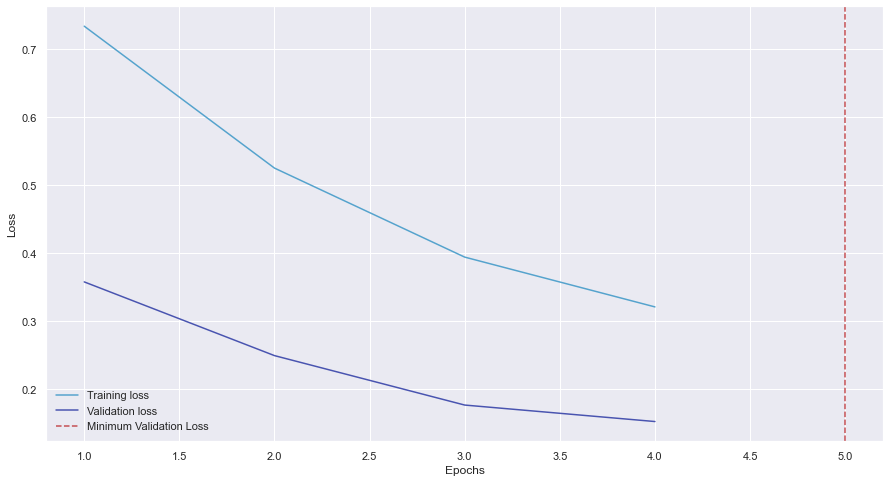

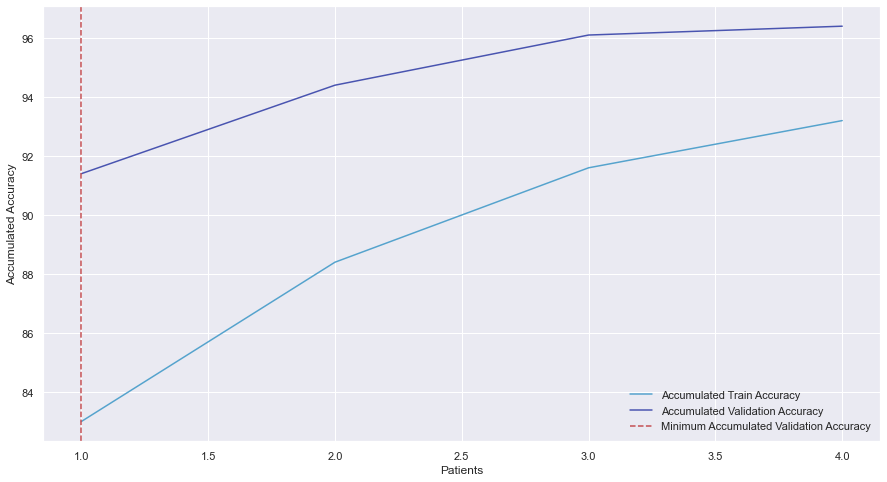

Train & validation losses-accuracy saved successfully


In [27]:
if MODEL_SELECTOR == 'FULL_FFN':
    model = Landmarks_Full()
    trainer = FFNTrainer(model, USE_FULL_DATA)
    trainer.start_loop()
    
else:
    model = Landmarks_Baseline()
    trainer = FFNTrainer(model, USE_FULL_DATA)
    trainer.start_loop()
    

Predicting




Predictions saved successfully


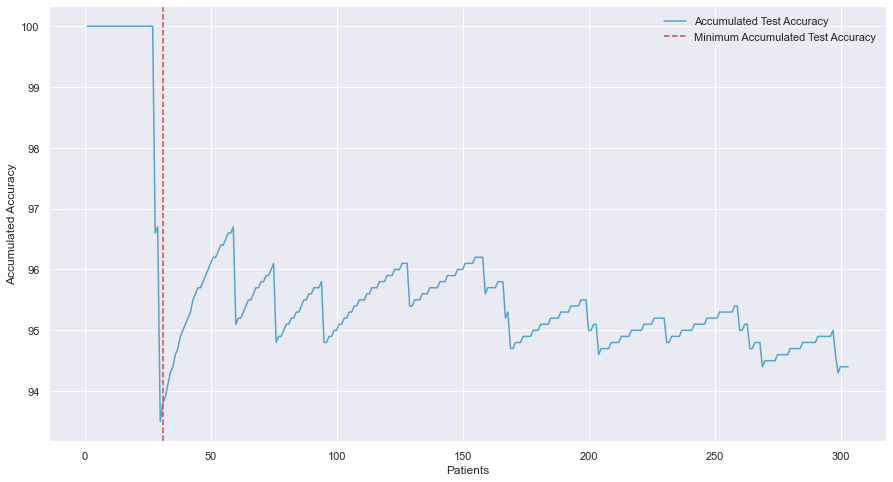

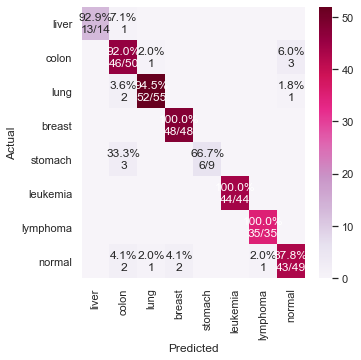

              precision    recall  f1-score   support

           0       1.00      0.93      0.96        14
           1       0.85      0.92      0.88        50
           2       0.96      0.95      0.95        55
           3       0.96      1.00      0.98        48
           4       1.00      0.67      0.80         9
           5       1.00      1.00      1.00        44
           6       0.97      1.00      0.99        35
           7       0.91      0.88      0.90        49

    accuracy                           0.94       304
   macro avg       0.96      0.92      0.93       304
weighted avg       0.95      0.94      0.94       304

Prediction successful
Overall test accuracy: 94.39999999999999 Overall test loss: 19.0


In [34]:
model_filename = 'ffn_2021-01-04_13.16.07.pth'
model_path = os.path.join(MODEL_PATH_DIR, model_filename)

if model_filename.startswith('b'):
    model = Landmarks_Baseline()
    model.load_state_dict(torch.load(model_path))
    trainer = FFNTrainer(model, USE_FULL_DATA)
    scores = trainer.predict(model_filename)

else:
    model = Landmarks_Full()
    model.load_state_dict(torch.load(model_path))
    trainer = FFNTrainer(model, USE_FULL_DATA)
    scores = trainer.predict(model_filename)
    